## **Vector Simulation**
---

>## 2-Link Manipulator

- **Scenario**
    - Initial conditions (manipulator arm hanging down): `x0 = [-3pi/8; 0.0; 0; 0]` (q1; q2; dq1; dq2)
    - First order ODE, no external force
- **Formulas** 
$$
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
x_2 \\
- D^{-1}(x_1) \cdot \left[ C(x_1, x_2) \cdot x_2 + G(x_1) \right] + D^{-1}(x_1) \cdot B\tau
\end{bmatrix}
$$
- **Key Takeaways**
    - Use the library function to get D, G, C ...
    - `dx1 = dq`;  `dx2 = (model.D) \ (-model.C*dq-model.G)`
    - Use the `ODEProblem` and `solve`

Packages used:
<span style="color:yellow; background-color:green">DifferentialEquations, Plots, LinearAlgebra, LaTeXStrings, Random</span>


In [2]:
using DifferentialEquations, Plots, LinearAlgebra, LaTeXStrings, Random
include("src/manipulator_library.jl")

cleanUp (generic function with 2 methods)

In [3]:
gr()

# 2-Link Manipulator Model
function modelParameters()
    g = 9.81
    L1 = 1.0
    L2 = 0.5
    m1 = 1.0
    m2 = 3.0
    return g, L1, L2, m1, m2
end

# define the ODE dx/dt = f(x,t)
#
# the parameters are passed via modelParameters() in the
# function dyn_mod_2LinkManipulator(q, dq)
#
function f(x,~,t)
    n = floor(Int, length(x) / 2) # In Julia n/2 is a Float64
    q = x[1:n]
    dq = x[n+1:end]
    model = dyn_mod_2LinkManipulator(q, dq)
    dx1 = dq
    dx2 = (model.D) \ (-model.C*dq-model.G) # note the use of backslash
    dx=[dx1;dx2]
    return dx
end

f (generic function with 1 method)

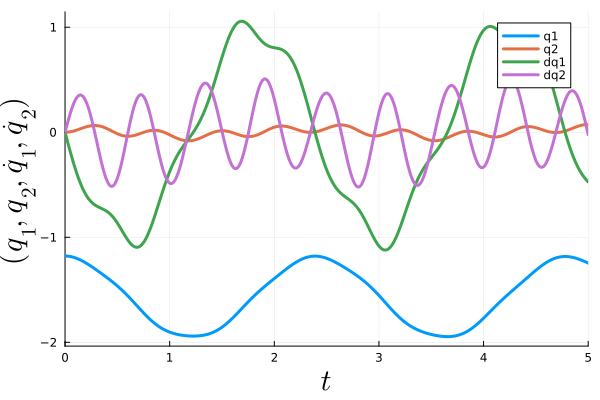

In [4]:
# Set the initial condition as a vector
x0= [-3pi/8; 0.0; 0; 0]

# Set the time interval
T = (0.0, 5) 

# Setup the ODE problem with out-of-place function
# params removed 
problem = ODEProblem{false}(f, x0, T)

# solve the ODE problem using the Runge Kutta Tsitouras 5/4 Integrator
sol = solve(problem, Tsit5());

# plot the solution
p1 = plot(sol, lw=3, guidefont=20, xlabel=L"t", ylabel=L"(q_1, q_2, \dot{q}_1, \dot{q}_2)", 
    label=["q1" "q2" "dq1" "dq2"], legend=:topright)

#png(p1, "2LinkManipulatorSimulationChap09")
display(p1)

>## 2-Link Manipulator with spring

- **Scenario**
    - 2-link manipulator with springs added to both revolute joints
    - Find the equilibrium point $q_e = [q_1^*; q_2^*]$
$$
x_e = \left\{ 
\begin{bmatrix}
q_e \\
0
\end{bmatrix}
\in \mathbb{R}^{2n} \ \middle| \ G(q_e) = 0_{n \times 1} 
\right\}
$$
- **Key Takeaways**
    - Use the library function to get G, JacG
    - Apply Newton-Raphson routine to find G($q_1^*$, $q_2^*$) = [0; 0]
$$
J(x_k) \, \Delta x = -G(x_k)\\
x_{k+1} = x_k + \Delta x
$$

In [5]:
# Starting point
x0 = [pi/2, pi/4]

Model = dyn_mod_2LinkManipulatorWithSprings(x0, 0*x0)
G = Model.G
JacG = Model.JacG
k = 0
aTol = 1e-5
s = 0.1
xk = x0

while (k<1e5)&&(norm(G)>aTol)
    k = k+1
    Delta_x = -JacG\G    
    xk = xk + s*Delta_x
    Model = dyn_mod_2LinkManipulatorWithSprings(xk, 0*xk)
    G = Model.G
    JacG = Model.JacG
end
Model = dyn_mod_2LinkManipulatorWithSprings(xk, 0*xk)
G = Model.G
JacG = Model.JacG

display(G)
# Equilibrium point xk 
[xk x0] 

2-element Vector{Float64}:
 -2.959527982682175e-6
  9.381671145725079e-6

2×2 Matrix{Float64}:
 -1.03536   1.5708
 -0.201158  0.785398

>## 3-Link Manipulator linear model

- **Scenario**
    - Linearize around the equilibrium point (Find Jacobian)
    - Equilibrium point given (`qe = [pi/2, 0, 0] || qe = [-pi/2, 0, 0]`)
$$
f(x) = f(x_e) + \left. \frac{\partial f(x)}{\partial x} \right|_{x = x_e} (x - x_e)
= \frac{\partial f(x_e)}{\partial x} \cdot (x - x_e)\\
{}\\
\dot{\delta x} = \frac{\partial f(x_e)}{\partial x} \cdot \delta x
$$
- **Robot Equation Stuff**
$$
D(q) \cdot \ddot{q} + C(q, \dot{q}) \cdot \dot{q} + G(q) = 0 \\
{}\\
\text{Linearized : } D(q_e) \cdot \delta\ddot{q} + \frac{\partial G(q_e)}{\partial q} \cdot \delta q = 0_{n \times 1}\\
{}\\
=> \begin{bmatrix}
\delta \dot{x}_1 \\
\delta \dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
0_n & I_n \\
A_{21} & 0_n
\end{bmatrix}
\begin{bmatrix}
\delta x_1 \\
\delta x_2
\end{bmatrix}\\
{}\\
\text{where} \quad A_{21} = -D(q_e) \backslash \frac{\partial G(q_e)}{\partial q}
$$

In [6]:
function modelParameters()
    g = 9.81 # m/s^2
    L1 = 1 # m
    L2 = 0.7
    L3 = 0.5
    m1 = 15 # kg
    m2 = 10
    m3 = 5    
    return g, L1, L2, L3, m1, m2, m3
end

# Set equilibirum Point
if true
    qe = [-pi/2, 0, 0]
else
    qe = [pi/2, 0, 0]
end

F = dyn_mod_3LinkManipulator(qe, 0*qe)
D = F.D; display(D)
JacG = F.JacG; display(JacG)

# build the linearized model about the give equilibrium point
A21 = -D\JacG; A21 = cleanUp(A21); display(A21)
n, ~ = size(A21)
A = [zeros(n,n) I(n); A21 zeros(n,n)]

# Eigenvalues
E=eigen(A)
evals = cleanUp(E.values); display(evals)

3×3 Matrix{Float64}:
 68.1  25.1  5.5
 25.1  12.1  3.0
  5.5   3.0  1.25

3×3 Matrix{Float64}:
 421.83   127.53   24.525
 127.53   127.53   24.525
  24.525   24.525  24.525

3×3 Matrix{Float64}:
 -9.81    9.81      0.0
  9.81  -37.8386    7.00714
  0.0    28.0286  -36.4371

6-element Vector{ComplexF64}:
 0.0 - 7.23885032225449im
 0.0 + 7.23885032225449im
 0.0 - 2.452784229773624im
 0.0 + 2.452784229773624im
 0.0 - 5.066419822703628im
 0.0 + 5.066419822703628im

>## 2-Link model - asymptotic stability analysis

- **Linear Model**: 
$$
\dot{\delta x} = \frac{\partial f(x_e)}{\partial x} \cdot \delta x  <==> x(t) = e^{At} \cdot  x_0 \\\\
A = \begin{bmatrix}
0_n & I_n \\
A_{21} & 0_n
\end{bmatrix}\\
$$
- **From Eigenvalues and Eigenvectors**
$$
\begin{aligned}
\text{Linear Combination of } x_0 &= a_1 v_1 + a_2 v_2 + ... + a_n v_n \\
{}\\
e^{At} \cdot  x_0 &= \Sigma_{i=1}^n e^{\lambda_i t} \cdot a_i v_i
\end{aligned}
$$
- **Norm of x(t)** => if one of the eigenvalue $\lambda_i$ is positive (and $a_i \ne 0$), the norm explodes !!!

In [7]:
# Define linear model for 2-Link Manipulator around the equilibrium point
function modelParameters()
    g = 9.81 # m/s^2
    L1 = 1 # m
    L2 = 0.7
    m1 = 15 # kg
    m2 = 10   
    return g, L1, L2, m1, m2
end

# Set equilibirum Point
if false
    qe = [-pi/2, 0] #downward
else
    qe = [pi/2, 0] # upward
end

F = dyn_mod_2LinkManipulator(qe, 0*qe)
D = F.D
JacG = F.JacG
B = F.B

# build the linearized model about the given equilibrium point
A21 = -D\JacG; A21 = cleanUp(A21)
n, ~ = size(A21)
A = [zeros(n,n) I(n); A21 zeros(n,n)]; display(A)
B = [zeros(n,n); F.D \ B]; display(B)
        
# Compute eigenvalues
E = eigen(A)      

4×4 Matrix{Float64}:
  0.0    0.0     1.0  0.0
  0.0    0.0     0.0  1.0
  9.81  -6.54    0.0  0.0
 -9.81  29.8971  0.0  0.0

4×2 Matrix{Float64}:
  0.0         0.0
  0.0         0.0
  0.0666667  -0.161905
 -0.161905    0.597279

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 -5.718391382198323
 -2.64710084000267
  2.647100840002673
  5.718391382198323
vectors:
4×4 Matrix{Float64}:
 -0.0473235   0.324822  0.324822  -0.0473235
  0.165632    0.139209  0.139209   0.165632
  0.270614   -0.859836  0.859836  -0.270614
 -0.947151   -0.368501  0.368501   0.947151

4×1 Matrix{Float64}:
 -0.9072986899852817
  0.7151631134658601
  1.6642140887375474
 -0.30858139151466624

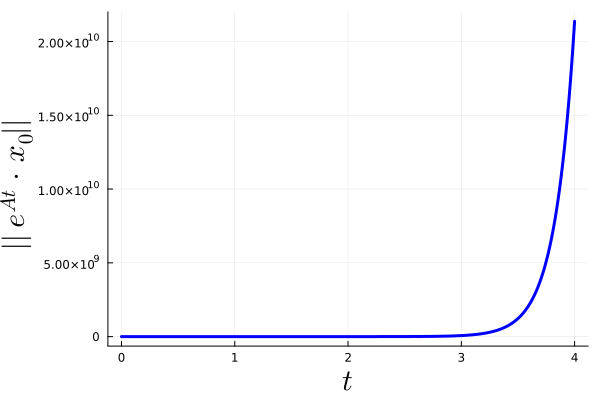

In [8]:
Random.seed!(543210)
x0 = randn(4,1); display(x0)
# Unless x0 is only the linear combination of the eigenvectors with negative eigenvalues, the solution will converge
# x0 = E.vectors[:,1] 
function normSolution(t; A=A, x0=x0)
    eAt = exp(A*t)
    xt = eAt * x0
    y = norm(xt)
    return y
end

# time values where we compute the solution
t = 0:0.01:4

y = normSolution.(t)

p1 = plot(t,y, guidefont = 20, legend = false, xlabel=L"t", ylabel=L"||e^{At}\cdot x_0 ||", lw=3, 
    color=:blue )

#png(p1, "NormSolutionX0randomDownwardEquilibrium2LinkArm")

>## 2-Link Model - Linear state-variable feedback control design

- **Linearized model with motors added to joints**
$$
\delta\dot{x} = A \cdot \delta x + B \cdot \delta \tau = 
\begin{bmatrix}
0.000 & 0.000 & 1.000 & 0.000 \\
0.000 & 0.000 & 0.000 & 1.000 \\
9.810 & -6.540 & 0.000 & 0.000 \\
-9.810 & 29.897 & 0.000 & 0.000
\end{bmatrix}
\delta x +
\begin{bmatrix}
0.000 & 0.000 \\
0.000 & 0.000 \\
0.067 & -0.162 \\
-0.162 & 0.597
\end{bmatrix}
\delta\tau
$$

- **Linear state-variable feedback control**: $\tau = - K \delta x$


In [9]:
K=[
 357.82  80.57  62.084   16.8291
  80.57  73.57  16.8291   6.92965
]
eigen(A-B*K)

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
4-element Vector{ComplexF64}:
 -0.7071159639815686 - 0.7070975982722693im
 -0.7071159639815686 + 0.7070975982722693im
 -0.7071061788755753 - 0.7071073834970106im
 -0.7071061788755753 + 0.7071073834970106im
vectors:
4×4 Matrix{ComplexF64}:
  0.223141-5.40185e-11im   0.223141+5.40185e-11im  …  -0.164817-0.164818im
 -0.670976-0.0im          -0.670976+0.0im             -0.472054-0.472055im
 -0.157786-0.157782im     -0.157786+0.157782im         0.233087+1.37153e-10im
  0.474458+0.474445im      0.474458-0.474445im         0.667586+0.0im

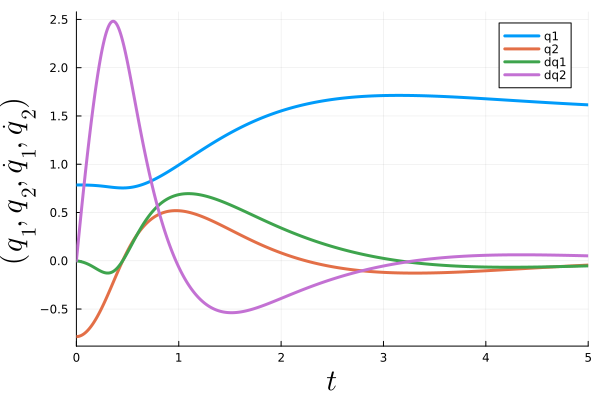

In [10]:
# Simulation
gr()

struct ParamsNL
    qe::Vector{Float64}
    K::Matrix{Float64}
end

params = ParamsNL(qe, K)

# Define the ODE
function f(x, params, t)
    n = floor(Int, length(x) / 2) # In Julia n/2 is a Float64
    q = x[1:n]
    dq = x[n+1:end]
    K = params.K
    qe = params.qe
    xe = [qe; 0*qe]
    tau = -K*(x-xe) # feedback control law
    model = dyn_mod_2LinkManipulator(q, dq)
    dx1 = dq
    dx2 = (model.D) \ (-model.C*dq-model.G+model.B*tau) # note the use of backslash
    dx=[dx1;dx2]
    return dx
end

# Set the initial condition as a vector
x0= [qe; 0*qe] - [pi/4; pi/4; 0; 0]

# Set the time interval
T = (0.0, 5)

# Setup the ODE problem with out-of-place function
problem = ODEProblem{false}(f, x0, T, params)

# solve the ODE problem using the Runge Kutta Tsitouras 5/4 Integrator
sol = solve(problem, Tsit5());

# plot the solution
p1 = plot(sol, lw=3, guidefont=20, xlabel=L"t", ylabel=L"(q_1, q_2, \dot{q}_1, \dot{q}_2)", 
    label=["q1" "q2" "dq1" "dq2"], legend=:topright)

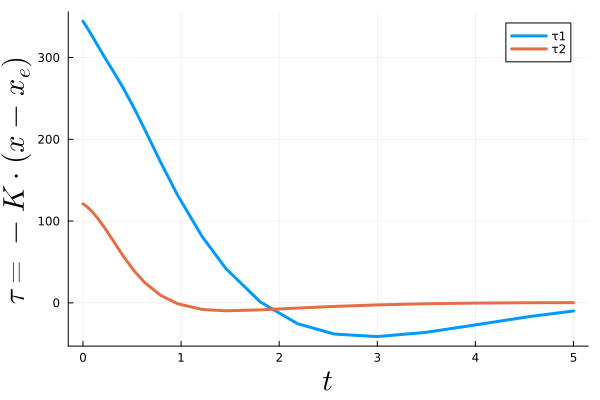

In [11]:
# Extract state variables from the solution
x_sol = Array(sol)

# Preallocate the array for control signals
tau_sol = zeros(2, size(x_sol,2))

# Define terms in the feedback controller
K = params.K
qe = params.qe
xe = [qe; 0*qe]

# Loop through the solution to compute control signals
for i in 1:size(x_sol,2)
    x = x_sol[:,i]
    tau_sol[:,i] = -K*(x-xe) # feedback control law
end

# Plot the control signals
p2 = plot(sol.t, tau_sol', lw=3, guidefont=20, xlabel=L"t", ylabel=L"\tau = -K \cdot(x-x_e)", 
          label=["τ1" "τ2"], legend=:topright)

Plots.AnimatedGif("d:\\CODING\\Julia\\ROB 201\\CH9\\inverted2LinkRobotArm.gif")
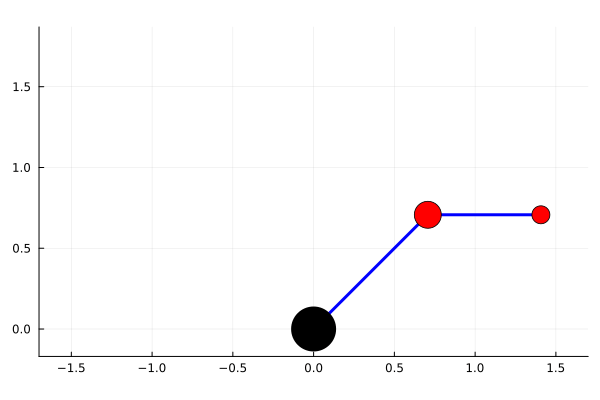

┌ Info: Saved animation to d:\CODING\Julia\ROB 201\CH9\inverted2LinkRobotArm.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\3u4B6\src\animation.jl:156


In [13]:
# Robot parameters
g, L1, L2, m1, m2 = modelParameters()

# Function to calculate forwardKinematics
function forwardKinematics(q1, q2)
    p1 = L1 * [cos(q1), sin(q1)]
    p2 = p1 + L2 * [cos(q1 + q2), sin(q1 + q2)]
    return p1, p2
end

# Extract q1 and q2 from the solution
q1_vals = x_sol[1, :]
q2_vals = x_sol[2, :]

# Create a plot for each time step and save as a GIF
anim = @animate for i in 1:length(q1_vals)
    p1, p2 = forwardKinematics(q1_vals[i], q2_vals[i])
    plot([0, p1[1], p2[1]], [0, p1[2], p2[2]], legend=false, lw=3, color=:blue,
        xlims=(-(L1+L2), L1+L2), ylims=(-(L1+L2)/10, 1.1*(L1+L2)), aspect_ratio=1)
    scatter!([p1[1]], [p1[2]], color=:red, markersize = m1)
    scatter!([p2[1]], [p2[2]], color=:red, markersize = m2)
    scatter!([0.0], [0.0], color=:black, markersize = m1+m2)
end

gif(anim, "inverted2LinkRobotArm.gif", fps = 10)